* Step1で作成した時系列の潜在変数をもとにRNNを訓練し、発話単語IDを推論する

In [1]:
import glob

feature_data_path = "./keras_log/run-20180901201647" #Step1での出力ディレクトリ
feature_files = glob.glob(feature_data_path + "/s*.npz")
feature_files_test = glob.glob(feature_data_path + "/*000.npz")

* 人物ごとに分かれている入力データを全部連結

In [2]:
import numpy as np

feature_datas = [np.load(f) for f in feature_files]
person_num = len(feature_files)
max_datalen = np.max([fd[fd.files[0]].shape[1] for fd in feature_datas])
word_types = 25
iter_num = 30

input_arrays = []
label_arrays = []
for fd in feature_datas:
    maindata = fd[fd.files[0]]
    labeldata = fd[fd.files[1]]
    pad_arr = np.empty((maindata.shape[0],max_datalen - maindata.shape[1],maindata.shape[2]))
    pad_arr[:,:,:] = np.nan
    input_arr = np.concatenate([maindata,pad_arr],axis=1).reshape((word_types, iter_num, max_datalen, maindata.shape[2]))
    input_arrays.append(input_arr)
    label_arrays.append(labeldata)

input_data = np.concatenate(input_arrays,axis=1)
label_data = np.vstack(label_arrays)
print(input_data.shape)
print(label_data.shape)

(25, 1080, 121, 16)
(36, 750)


* 入力データ素性を確認
* 同一人物、同一単語なら潜在変数の変動も似たパターンになっていることを期待
* 同一人物、違う単語なら違うパターンになっていることが期待
* 同じ単語なら人物が異なっても似たパターンが見いだせることが期待

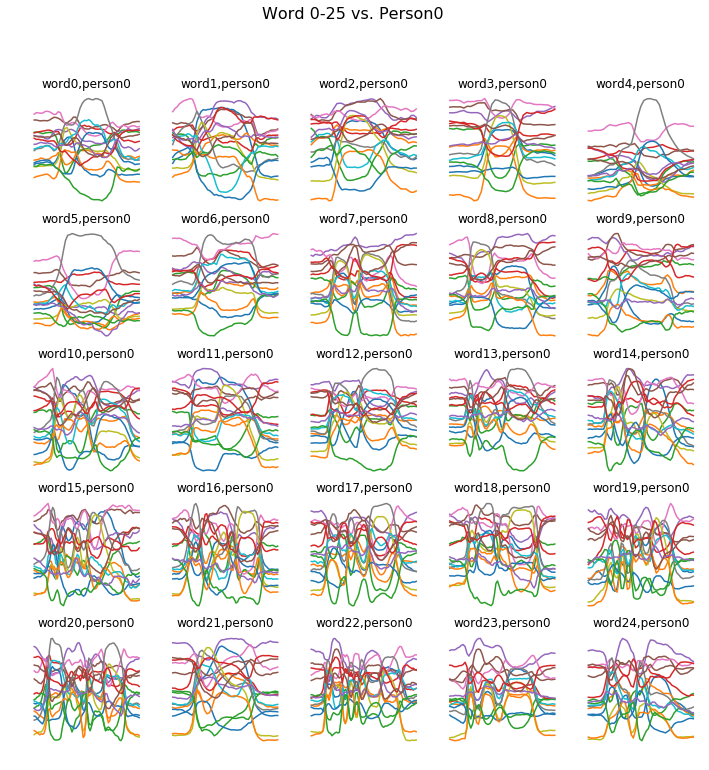

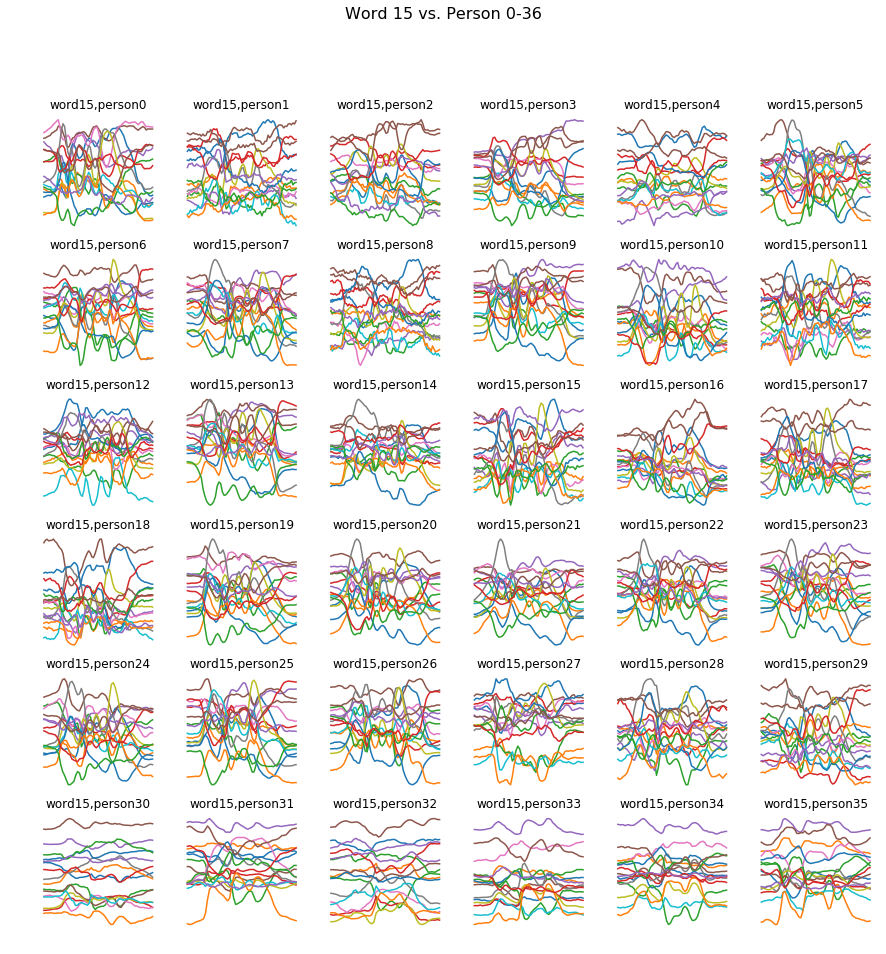

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(nrows=5,ncols=5,figsize=(12,12))
sample_person_id = 0
for i in range(word_types):
    ax[i//5,i%5].plot(range(max_datalen),input_data[i,sample_person_id,:,:])
    ax[i//5,i%5].set_title("word{},person{}".format(i,sample_person_id))
    ax[i//5,i%5].set_axis_off()
plt.suptitle("Word 0-{} vs. Person{}".format(word_types,sample_person_id),fontsize=16)
plt.show()

fig,ax = plt.subplots(nrows=6,ncols=6,figsize=(15,15))
sample_word_id = 15
for i in range(person_num):
    ax[i//6,i%6].plot(range(max_datalen),input_data[sample_word_id,i,:,:])
    ax[i//6,i%6].set_title("word{},person{}".format(sample_word_id,i))
    ax[i//6,i%6].set_axis_off()
plt.suptitle("Word {} vs. Person 0-{}".format(sample_word_id,person_num),fontsize=16)
plt.show()

* 可変長RNNに入力するため、データ長の配列を作成
* データの最終以降が全てnp.nan埋めされているの前提
* 処理間違っていないかの確認のため、算出されたデータ長の分布を表示

(25, 1080)
(25, 1080)


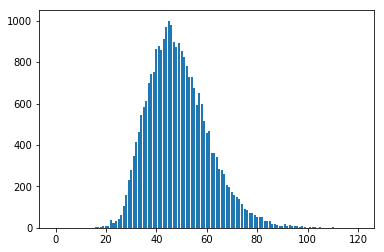

In [4]:
label = np.arange(word_types).repeat(iter_num * person_num).reshape((word_types,-1))
lengths = input_data.shape[2] - np.count_nonzero(np.isnan(input_data[:,:,:,0]),axis=2)
print(label.shape)
print(lengths.shape)

length_count = [np.sum(lengths == x) for x in range(input_data.shape[2])]

fig,ax = plt.subplots(nrows=1,ncols=1)
ax.bar(np.arange(input_data.shape[2]),length_count)
plt.show()

* 訓練データ＋データ長＋ラベルをシャッフルし、訓練セットと検証セットに分割
* データ数多くないので訓練割合を多め、本当はk交差やるべき

In [5]:
input_data_flat = input_data.reshape((-1,input_data.shape[2],input_data.shape[3]))
label_flat = label.flatten()
length_flat = lengths.flatten()

np.random.seed(3939)
random_index = np.random.permutation(len(label_flat))
input_data_flat = input_data_flat[random_index,:,:]
label_flat = label_flat[random_index]
length_flat = length_flat[random_index]

numtrain = len(input_data_flat) * 9 // 10
train_x,train_y,train_length = input_data_flat[:numtrain],label_flat[:numtrain],length_flat[:numtrain]
valid_x,valid_y,valid_length = input_data_flat[numtrain:],label_flat[numtrain:],length_flat[numtrain:]

print(train_x.shape,train_y.shape,train_length.shape)
print(valid_x.shape,valid_y.shape,valid_length.shape)

(24300, 121, 16) (24300,) (24300,)
(2700, 121, 16) (2700,) (2700,)


* 手順が間違っていないか、訓練データと検証データの素性を再度確認
* 同じラベルなら似たようなパターンが見いだせる事を期待
* 訓練データと検証データのパターンが同様であることを期待

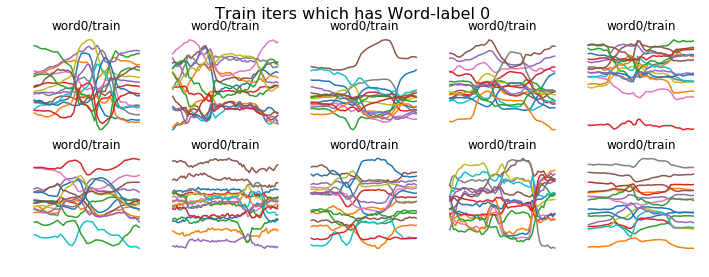

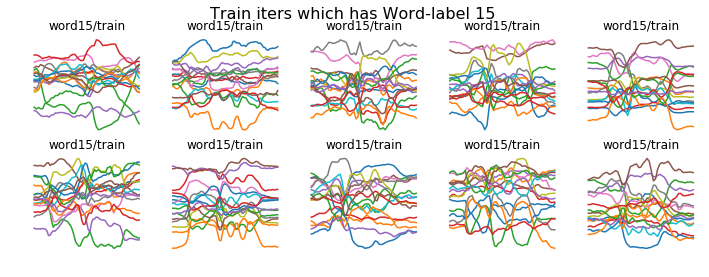

In [6]:
sample_word_id_1 = 0 #Person0で比較的シンプルに見えたラベル
sample_word_id_2 = 15 #Person0で比較的複雑に見えたラベル

train_for_word1 = train_x[train_y==sample_word_id_1]
train_for_word2 = train_x[train_y==sample_word_id_2]

fix,ax = plt.subplots(nrows=2,ncols=5,figsize=(12,4))
for i in range(10):
    ax[i//5,i%5].plot(range(max_datalen),train_for_word1[i,:,:])
    ax[i//5,i%5].set_title("word{}/train".format(sample_word_id_1))
    ax[i//5,i%5].set_axis_off()
plt.suptitle("Train iters which has Word-label {}".format(sample_word_id_1),fontsize=16)
plt.show()

fix,ax = plt.subplots(nrows=2,ncols=5,figsize=(12,4))
for i in range(10):
    ax[i//5,i%5].plot(range(max_datalen),train_for_word2[i,:,:])
    ax[i//5,i%5].set_title("word{}/train".format(sample_word_id_2))
    ax[i//5,i%5].set_axis_off()
plt.suptitle("Train iters which has Word-label {}".format(sample_word_id_2),fontsize=16)
plt.show()

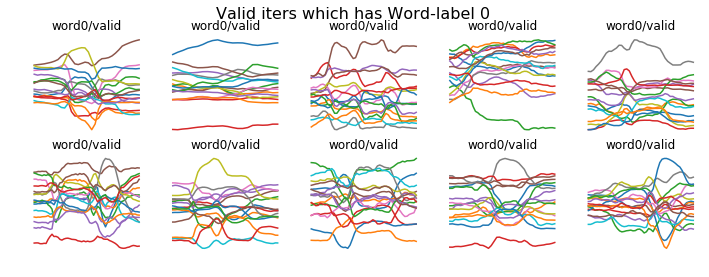

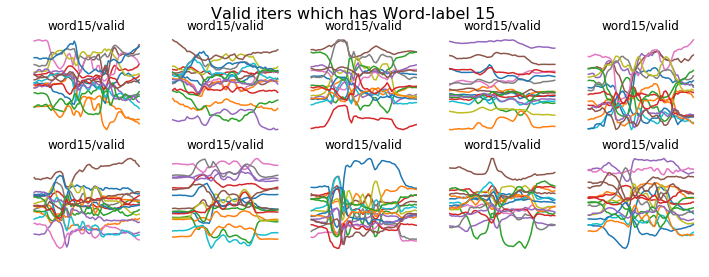

In [7]:
valid_for_word1 = valid_x[valid_y==sample_word_id_1]
valid_for_word2 = valid_x[valid_y==sample_word_id_2]

fix,ax = plt.subplots(nrows=2,ncols=5,figsize=(12,4))
for i in range(10):
    ax[i//5,i%5].plot(range(max_datalen),valid_for_word1[i,:,:])
    ax[i//5,i%5].set_title("word{}/valid".format(sample_word_id_1))
    ax[i//5,i%5].set_axis_off()
plt.suptitle("Valid iters which has Word-label {}".format(sample_word_id_1),fontsize=16)
plt.show()

fix,ax = plt.subplots(nrows=2,ncols=5,figsize=(12,4))
for i in range(10):
    ax[i//5,i%5].plot(range(max_datalen),valid_for_word2[i,:,:])
    ax[i//5,i%5].set_title("word{}/valid".format(sample_word_id_2))
    ax[i//5,i%5].set_axis_off()
plt.suptitle("Valid iters which has Word-label {}".format(sample_word_id_2),fontsize=16)
plt.show()

* RNNにnp.nanを突っ込めないので0パディング
* ここまで引っ張っているのは（最初のconcatenate時でないのは）matplotlibでの表示都合のため

In [8]:
train_x[np.isnan(train_x)] = 0
valid_x[np.isnan(valid_x)] = 0

* RNN構築、パラメタ数も少ないのでLSTM/GRU一層（これでもすぐ過学習に陥る）

In [9]:
import tensorflow as tf
import numpy as np

n_steps = train_x.shape[1]
n_inputs = train_x.shape[2]
n_neurons = 200
n_outputs = word_types

tf.reset_default_graph()
X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.int32,[None])
seqlen = tf.placeholder(tf.int32,[None])
input_keep = tf.placeholder_with_default(1.0, shape=())
state_keep = tf.placeholder_with_default(1.0, shape=())
lr = tf.placeholder_with_default(1e-4,shape=())

X_rnninput = tf.reshape(X,[-1,n_steps,n_inputs])
with tf.variable_scope("rnn",initializer=tf.variance_scaling_initializer()):
    #rnncell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons,activation=tf.nn.elu,state_is_tuple=False)
    rnncell = tf.contrib.rnn.GRUCell(num_units=n_neurons,activation=tf.nn.elu)
cell_drop = tf.contrib.rnn.DropoutWrapper(rnncell,input_keep_prob=input_keep,state_keep_prob=state_keep)
output, states = tf.nn.dynamic_rnn(cell_drop, X_rnninput, dtype=tf.float32, sequence_length=seqlen)

logits = tf.layers.dense(states,n_outputs)
loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits))
train = tf.train.AdamOptimizer(lr).minimize(loss)
correct = tf.nn.in_top_k(logits,y,1)
predict = tf.argmax(logits,1)
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

* 訓練実施、検証データの正答率を見ながら重み情報を保存しておく

In [29]:
from datetime import datetime
import os

batch_size = 1080
numepoch = 1000
checkpt_per_epochs = 50
#ログ出力用設定、日時名のフォルダを指定
saver = tf.train.Saver(max_to_keep=numepoch//checkpt_per_epochs)
logdir = "./tf_log/run-{}/".format(datetime.utcnow().strftime("%Y%m%d%H%M%S"))
if not os.path.exists(logdir):
    os.makedirs(logdir)

input_keep_in_train = 0.95
state_keep_in_train = 0.9

acc_log = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(numepoch):
        for iteration in range(len(train_x) // batch_size):
            x_batch = train_x[batch_size * iteration:batch_size * (iteration + 1),:,:]
            y_batch = train_y[batch_size * iteration:batch_size * (iteration + 1)]
            len_batch = train_length[batch_size * iteration:batch_size * (iteration + 1)]

        if (epoch + 1) % checkpt_per_epochs == 0:
            saver.save(sess,logdir + "SSSD_{}.ckpt".format(epoch+1))
            acc_train = accuracy.eval(feed_dict={X: x_batch, y:y_batch, seqlen:len_batch})
            acc_test = accuracy.eval({X: valid_x, y:valid_y, seqlen:valid_length})
            pred = predict.eval({X: valid_x, seqlen:valid_length})
            acc_log.append((acc_train,acc_test))
            print("epoch={},acc_train={:.5f},acc_test={:5f}".format(epoch+1,acc_train,acc_test))
            print("pred={}..".format(pred[:20]))
            print("corr={}..".format(valid_y[:20]))
        
        sess.run(train, feed_dict={
            X:x_batch,y:y_batch,seqlen:len_batch,
            input_keep:input_keep_in_train,
            state_keep:state_keep_in_train,
            lr:4e-4
        })

epoch=50,acc_train=0.19444,acc_test=0.119259
pred=[10 12  0  5 19  7  8 22 17 22 11 22 20 20 19 12  5 12  7 12]..
corr=[ 4 23 13  6  2 24  3 15  0 21 23  3 21 23 22 10  9 10 11 12]..
epoch=100,acc_train=0.35000,acc_test=0.205185
pred=[10  4  0  5 19  7  8 16  4 22  7  2 14 22 19 10  6 10  3 12]..
corr=[ 4 23 13  6  2 24  3 15  0 21 23  3 21 23 22 10  9 10 11 12]..
epoch=150,acc_train=0.45926,acc_test=0.256667
pred=[ 0  2  0  5 19 19  3 17  0  2  7  2 14  2 19 10  6 10  7 12]..
corr=[ 4 23 13  6  2 24  3 15  0 21 23  3 21 23 22 10  9 10 11 12]..
epoch=200,acc_train=0.56852,acc_test=0.300370
pred=[ 0  1 12  5 19 19  3 16  0  2  7  2 21  2 19 10  5  0  2 12]..
corr=[ 4 23 13  6  2 24  3 15  0 21 23  3 21 23 22 10  9 10 11 12]..
epoch=250,acc_train=0.66481,acc_test=0.334815
pred=[ 0  9 12  5 19 22  3 22  0  2 23  2 21  2 19 10  6  1  2 12]..
corr=[ 4 23 13  6  2 24  3 15  0 21 23  3 21 23 22 10  9 10 11 12]..
epoch=300,acc_train=0.71852,acc_test=0.340370
pred=[ 0  9 12  5 19 19  3 22  0  2

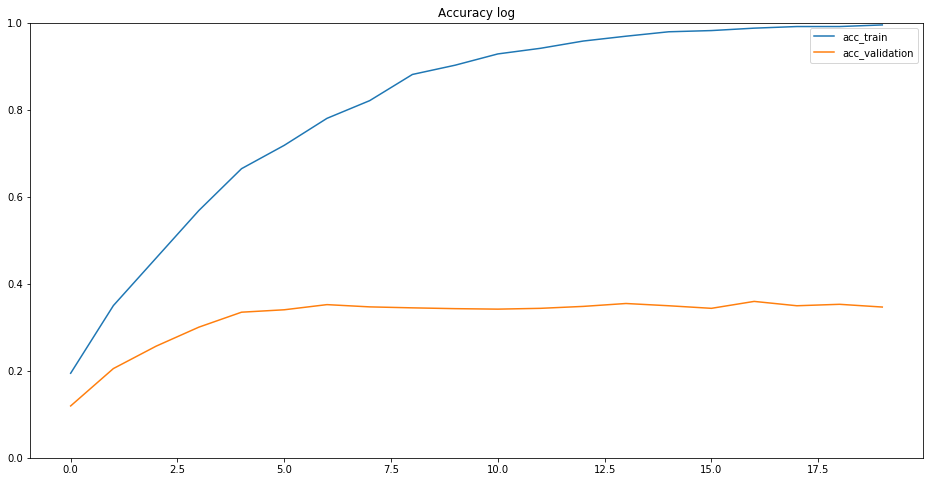

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
log_arr = np.asarray(acc_log)
epochs = range((numepoch)//checkpt_per_epochs)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
plt.title("Accuracy log")
ax.plot(epochs, log_arr[:,0],label="acc_train")
ax.plot(epochs, log_arr[:,1],label="acc_validation")
ax.legend()
ax.set_ylim(0.,1.0)
plt.show()

best_ckpt_id = np.argmax(log_arr[:,1])

* テストデータを訓練データ同様に処理
* 一番検証データ正答率が高かった時点の重みを読み出し
* 結果(R-file)の保存

In [31]:
feature_datas_test = [np.load(f) for f in feature_files_test]

test_arrays = []
for fd in feature_datas_test:
    maindata = fd[fd.files[0]]
    pad_arr = np.empty((maindata.shape[0],max_datalen - maindata.shape[1],maindata.shape[2]))
    pad_arr[:,:,:] = np.nan
    input_arr = np.concatenate([maindata,pad_arr],axis=1).reshape((-1, max_datalen, maindata.shape[2]))
    test_arrays.append(input_arr)

test_data = np.concatenate(test_arrays,axis=0)
test_length = test_data.shape[1] - np.count_nonzero(np.isnan(test_data[:,:,0]),axis=1)
print(test_data.shape)
print(test_length.shape)

(5000, 121, 16)
(5000,)


In [32]:
with tf.Session() as sess:
    saver.restore(sess, logdir + "SSSD_{}.ckpt".format((best_ckpt_id+1) * checkpt_per_epochs))
    pred = predict.eval({X: valid_x, seqlen:valid_length})
    result = predict.eval({X: test_data, seqlen:test_length})

#テストデータをR-fileとして書き込み
print(result[:10])
np.savetxt(logdir + "R-file", result[:,np.newaxis],fmt="%d")
#R-fileの中身チェック
with open(logdir + "R-file","r") as rfile:
    l = rfile.readlines()
    print(l[:10])

INFO:tensorflow:Restoring parameters from ./tf_log/run-20180902003012/SSSD_850.ckpt
[17 19 18  1  2  6 21 19 21 16]
['17\n', '19\n', '18\n', '1\n', '2\n', '6\n', '21\n', '19\n', '21\n', '16\n']


Validation Dataを使い、発話内容ごとの正答率を確認してみる

|word id|発話内容|word id|発話内容|word id|発話内容|
|---|---|---|---|---|---|
|00|ぜろ|10|ありがとう|20|どういたしまして|
|01|いち|11|いいえ|21|はい|
|02|に|12|おはよう|22|はじめまして|
|03|さん|13|おめでとう|23|またね|
|04|よん|14|おやすみ|24|もしもし|
|05|ご|15|ごめんなさい|||
|06|ろく|16|こんにちは|||
|07|なな|17|こんばんわ|||
|08|はち|18|さようなら|||
|09|きゅう|19|すみません|||

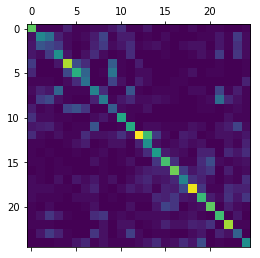

word00 accuracy: 0.556818%(49/88)	word00(49)	word10(8)	word04(6)	word13(4)	word09(4)	
word01 accuracy: 0.250000%(30/120)	word01(30)	word02(24)	word08(13)	word23(11)	word03(6)	
word02 accuracy: 0.126126%(14/111)	word01(17)	word02(14)	word03(11)	word08(11)	word23(9)	
word03 accuracy: 0.314286%(33/105)	word03(33)	word21(11)	word02(11)	word23(10)	word07(8)	
word04 accuracy: 0.467213%(57/122)	word04(57)	word09(19)	word05(15)	word00(11)	word06(8)	
word05 accuracy: 0.338843%(41/121)	word05(41)	word09(25)	word06(21)	word04(14)	word00(7)	
word06 accuracy: 0.352941%(24/68)	word06(24)	word09(13)	word05(8)	word24(6)	word12(5)	
word07 accuracy: 0.245763%(29/118)	word07(29)	word03(21)	word11(17)	word21(13)	word08(8)	
word08 accuracy: 0.221311%(27/122)	word08(27)	word21(23)	word02(14)	word01(11)	word22(7)	
word09 accuracy: 0.240506%(19/79)	word09(19)	word05(16)	word04(13)	word06(10)	word00(5)	
word10 accuracy: 0.582090%(39/67)	word10(39)	word00(9)	word08(4)	word22(3)	word01(2)	
word11 accuracy: 0.357

In [33]:
ones = np.ones_like(pred)
pred_y_matrix = np.array(
    [np.sum(ones[np.logical_and(pred==i,valid_y==j)]) for i in range(word_types) for j in range(word_types)]
).reshape((word_types,word_types))
plt.matshow(pred_y_matrix)
plt.show()

for i in range(word_types):
    print("word{:02d} accuracy: {:01f}%({}/{})".format(
        i,
        pred_y_matrix[i,i] / np.sum(pred == i),
        pred_y_matrix[i,i],
        np.sum(pred == i)
    ),end="\t")
    sortid = np.argsort(pred_y_matrix[i,:])
    for j in range(5):
        print("word{:02d}({})".format(sortid[-1-j],pred_y_matrix[i,sortid[-1-j]]), end="\t")
    print("")